In [43]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute, quantum_info

In [9]:
# Unitary 4 Qubit gate with Rz's full entanglement
def even_gate(theta, index):
    name = "Ue"+str(index)+"("+str(theta)+")"
    u_even = QuantumCircuit(4, name=name)
    u_even.rz(theta,0)
    u_even.rz(theta,1)
    u_even.rz(theta,2)
    u_even.rz(theta,3)

    u_even.cz(0,1)
    u_even.cz(0,2)
    u_even.cz(0,3)
    u_even.cz(1,2)
    u_even.cz(0,3)
    u_even.cz(2,3)

    return u_even

# Unitary 4 Qubit gate with Rx's and no entanglement
def odd_gate(theta, index):
    name = "Uo"+str(index)+"("+str(theta)+")"
    u_odd = QuantumCircuit(4, name=name)
    u_odd.rx(theta,0)
    u_odd.rx(theta,1)
    u_odd.rx(theta,2)
    u_odd.rx(theta,3)

    return u_odd

In [36]:
def calculate_theta():
    return np.random.uniform(0, 2*np.pi)

In [76]:
L = 3
phi = quantum_info.random_statevector(16)
circuit = QuantumCircuit(4)

for i in range(L):
    theta = calculate_theta()
    circuit.append(even_gate(theta, i), [0, 1, 2, 3])
    theta = calculate_theta()
    circuit.append(odd_gate(theta, i), [0, 1, 2, 3])
    
circuit.draw()

┌────────────────────────┐┌──────────────────────────┐»
q_0: ┤0                       ├┤0                         ├»
     │                        ││                          │»
q_1: ┤1                       ├┤1                         ├»
     │  Ue0(3.60227917189017) ││  Uo0(3.2486155601283304) │»
q_2: ┤2                       ├┤2                         ├»
     │                        ││                          │»
q_3: ┤3                       ├┤3                         ├»
     └────────────────────────┘└──────────────────────────┘»
«     ┌─────────────────────────┐┌──────────────────────────┐»
«q_0: ┤0                        ├┤0                         ├»
«     │                         ││                          │»
«q_1: ┤1                        ├┤1                         ├»
«     │  Ue1(4.798106133801536) ││  Uo1(2.6489732281904175) │»
«q_2: ┤2                        ├┤2                         ├»
«     │                         ││                          │»
«q_3: ┤3                        ├┤3                         ├»
«     └─────────────────────────┘└──────────────────────────┘»
«     ┌──────────────────────────┐┌──────────────────────────┐
«q_0: ┤0                         ├┤0                         ├
«     │                          ││                          │
«q_1: ┤1                         ├┤1                         ├
«     │  Ue2(1.6026662121125612) ││  Uo2(1.4192789539333643) │
«q_2: ┤2                         ├┤2                         ├
«     │                          ││                          │
«q_3: ┤3                         ├┤3                         ├
«     └──────────────────────────┘└──────────────────────────┘

In [29]:
simulator = Aer.get_backend("statevector_simulator")

job = execute(circuit, backend=simulator, shots=1024)
result = job.result()
phi_theta = result.get_statevector(circuit)
print(phi_theta)

[ 0.67916225-0.5060647j  -0.07766422+0.1016488j  -0.07766422+0.1016488j
  0.06417263-0.16355447j  0.00267306+0.05143571j  0.11266673-0.09793946j
  0.11266673-0.09793946j  0.2247239 +0.05571224j -0.18110621+0.13247225j
  0.05445673+0.02481664j  0.05445673+0.02481664j -0.06745192+0.10243677j
  0.07522207-0.15772319j  0.04838722+0.04549086j  0.04838722+0.04549086j
 -0.0299657 +0.07350253j]


In [74]:
# Quick test before we start optimizing thetas

results = []
L = 5

for chosen_l in range(L):
    circuit = QuantumCircuit(4)

    for i in range(chosen_l):
        theta = calculate_theta()
        circuit.append(even_gate(theta, i), [0, 1, 2, 3])
        theta = calculate_theta()
        circuit.append(odd_gate(theta, i), [0, 1, 2, 3])
        
    job = execute(circuit, backend=simulator, shots=1024)
    result = job.result()
    phi_theta = result.get_statevector(circuit)
    distance = np.linalg.norm(phi_theta - phi.data)
    print(distance)
    results.append(distance)

1.4771909433102395
1.4347736974785457
1.579183048111628
1.4009944503018403
1.3288168383133794


Text(0, 0.5, 'Epsilon')

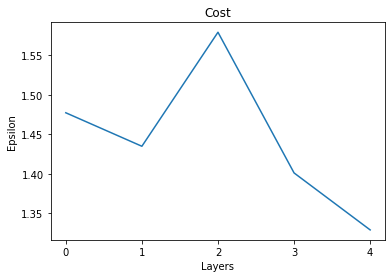

In [75]:
x_axis = list(range(L))
plt.xticks(x_axis)
plt.plot(x_axis, results)
plt.title('Cost')
plt.xlabel('Layers')
plt.ylabel('Epsilon')